
# Galaxy shear

This example simulates a galaxy catalogue with shears affected by weak lensing,
combining the :doc:`/basic/plot_density` and :doc:`/basic/plot_lensing` examples
with generators for the intrinsic galaxy ellipticity and the resulting shear.


## Setup
The setup of galaxies and weak lensing fields is the same as in the basic
examples.  We reuse the precomputed angular matter power spectra from the
:doc:`/basic/shells` example, and we set up the same CAMB cosmology to obtain
the ``cosmo`` object.



In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# GLASS modules: cosmology and everything in the glass namespace
import glass.shells
import glass.fields
import glass.points
import glass.shapes
import glass.lensing
import glass.galaxies
from glass.core.constants import ARCMIN2_SPHERE


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 256

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 1., dx=200.)

# tophat window function for shells
ws = glass.shells.tophat_windows(zb)

# load the angular matter power spectra previously computed with CAMB
cls = np.load('../1-basic/cls.npy')

## Matter



In [2]:
# compute Gaussian cls for lognormal fields for 3 correlated shells
# putting nside here means that the HEALPix pixel window function is applied
gls = glass.fields.lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=3)

# generator for lognormal matter fields
matter = glass.fields.generate_lognormal(gls, nside, ncorr=3)

## Lensing



In [3]:
# this will compute the convergence field iteratively
convergence = glass.lensing.MultiPlaneConvergence(cosmo)

## Galaxy



In [4]:
# standard deviation in each component of galaxy ellipticity
# this is very small so that the galaxy density can be small, too
sigma_e = 0.01

# galaxy number density per arcmin2, over all shells
n_arcmin2 = 0.01

# localised redshift distribution with the given density
z = np.arange(0., 2., 0.01)
dndz = np.exp(-(z - 0.5)**2/(0.1)**2)
dndz *= n_arcmin2/np.trapz(dndz, z)

## Simulation
Simulate the galaxies with shears.  In each iteration, get the shears and map
them to a HEALPix map for later analysis.

In addition, generate the galaxy ellipticities, drawn from the intrinsic
normal distribution.  The standard deviation is much too small to be
realistic, but enables the example to get away with fewer total galaxies.

Finally, apply the reduced shear from the lensing maps to the galaxy
ellipticities, producing the galaxy shears.



In [5]:
# number of HEALPix pixels in the maps
npix = 12*nside**2

# map for galaxy numbers
num = np.zeros(npix)

# map for sum of shears
she = np.zeros(npix, dtype=complex)

# simulate the matter fields in the main loop
for i, delta_i in enumerate(matter):

    # compute the lensing maps for this shell
    convergence.add_window(delta_i, ws[i])
    kappa_i = convergence.kappa
    gamm1_i, gamm2_i = glass.lensing.shear_from_convergence(kappa_i)

    # true galaxy redshift distribution in this shell
    z_i, dndz_i = glass.shells.restrict(z, dndz, ws[i])

    # galaxy density in this shell
    ngal = np.trapz(dndz_i, z_i)

    # generate galaxy positions uniformly over the sphere
    for gal_lon, gal_lat, gal_count in glass.points.uniform_positions(ngal):

        # generate galaxy ellipticities from the chosen distribution
        gal_eps = glass.shapes.ellipticity_intnorm(gal_count, sigma_e)

        # apply the shear fields to the ellipticities
        gal_she = glass.galaxies.galaxy_shear(gal_lon, gal_lat, gal_eps,
                                            kappa_i, gamm1_i, gamm2_i)

        # map the galaxy shears to a HEALPix map; this is opaque but works
        gal_pix = hp.ang2pix(nside, gal_lon, gal_lat, lonlat=True)
        s = np.argsort(gal_pix)
        pix, start, count = np.unique(gal_pix[s], return_index=True, return_counts=True)
        num[pix] += count
        she[pix] += list(map(np.sum, np.split(gal_she[s], start[1:])))

## Analysis
Compute the angular power spectrum of the observed galaxy shears.  To compare
with the expectation, take into account the expected noise level due to shape
noise, and the expected mixing matrix for a uniform distribution of points.



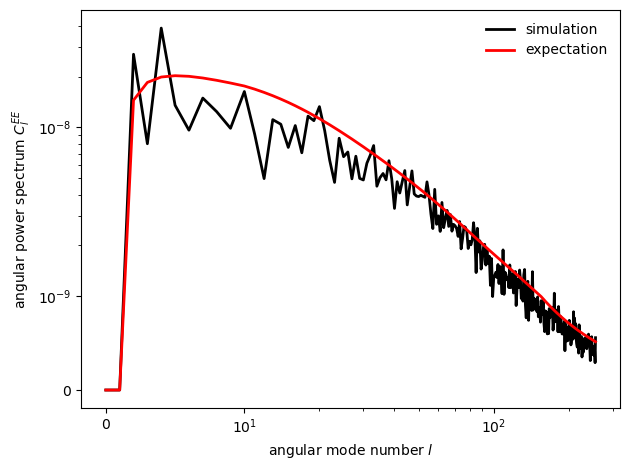

In [6]:
# compute the expected number of galaxies in each pixel
nbar = ARCMIN2_SPHERE/npix*n_arcmin2

# normalise the maps by the expected number of galaxies in each pixel
she /= nbar
num /= nbar

# get the angular power spectra from the galaxy shears
cls = hp.anafast([num, she.real, she.imag], pol=True, lmax=lmax, use_pixel_weights=True)

# get the theory cls from CAMB
pars.NonLinear = 'NonLinear_both'
pars.Want_CMB = False
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

# factor transforming convergence to shear
l = np.arange(lmax+1)
fl = (l+2)*(l+1)*l*(l-1)/np.clip(l**2*(l+1)**2, 1, None)

# the noise level from discrete observations with shape noise
nl = 4*np.pi/(nbar*npix)*sigma_e**2 * (l >= 2)

# mixing matrix for uniform distribution of points
mm = (1 - 1/(nbar*npix))*np.eye(lmax+1, lmax+1) + (l+1/2)/(nbar*npix)
mm[:2, :] = mm[:, :2] = 0

# the shear pixel window function for HEALPix
_, pw = hp.pixwin(nside, lmax=lmax, pol=True)

# plot the realised and expected cls
plt.plot(l, cls[1] - nl, '-k', lw=2, label='simulation')
plt.plot(l, pw**2 * mm@(fl*theory_cls['W1xW1']), '-r', lw=2, label='expectation')
plt.xscale('symlog', linthresh=10, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.yscale('symlog', linthresh=1e-9, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel('angular mode number $l$')
plt.ylabel('angular power spectrum $C_l^{EE}$')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()